<a href="https://colab.research.google.com/github/vilcagamarracf/Inv_arroz_METRIC/blob/main/notebooks/2_Balance_de_Energ%C3%ADa_Superficial_Modelo_METRIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Balance de Energía Superficial Modelo METRIC

Segunda Libreta sobre el trabajo de investigación: 
> **Replicación del Modelo METRIC para estimar evapotranspiración de manera espacio-temporal usando imágenes satelitales en la plataforma Google Earth Engine.** 

- Zona de estudio: Distrito de Chongoyae, Provincia de Chiclayo, Lambayeque

## Inicio

##### Credenciales

In [1]:
# # Ingresa tus credenciales de Google Earth Engine para comenzar
# import ee
# ee.Authenticate()

# # Inicio
# ee.Initialize()

# # Mensaje de login
# print('\nYa estás logeado.')
# print('GEE Version:', ee.__version__)

In [2]:
#@markdown *Credenciales Google Earth Engine: Forma rápida*
import os 
credential = '{"refresh_token":"1//09lhqedCNpNDsCgYIARAAGAkSNwF-L9IraEP8FyJma46WSiEHhOMsZqSoTPJsi3Lar0C4nZUwj2QCZ_i66-McVzy4NmMalQL17KM"}'
credential_file_path = os.path.expanduser("~/.config/earthengine/")
os.makedirs(credential_file_path,exist_ok=True)
with open(credential_file_path + 'credentials', 'w') as file:
    file.write(credential)
import ee
ee.Initialize()
print('Ya estás logeado.')
print('GEE Version:',ee.__version__)

Ya estás logeado.
GEE Version: 0.1.295


##### geemap

In [3]:
# Instalar geemap
%%capture
!pip install -U geemap # Nota: Con la actualización de ipyleaflet v0.15.0 se produjo un conflicto con geemap
# !pip install geemap==0.10.1

Documentación `geemap`
- [geemap - key features](https://geemap.org/notebooks/00_geemap_key_features/)

In [4]:
import geemap
# import geemap.eefolium as geemap
Map = geemap.Map(basemap='HYBRID', center=(-9.125, -74.396), zoom=5) # basemap='HYBRID', 'OpenStreetMap.Mapnik' 
Map

Map(center=[-9.125, -74.396], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

##### Funciones

In [5]:
# Mejorar visibilidad de tablas en Colab
%load_ext google.colab.data_table

# Para volver al estado original de las tablas
# %unload_ext google.colab.data_table

In [6]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates # Modificar fechas por formato
date_format = mpl_dates.DateFormatter('%Y-%m')

## Balance de Energía Superficial

### Radiación Neta $R_n$

#### Funciones Radiación Neta

In [7]:
# @markdown Assets: Departamentos, Provincias y Distritos
# Ejemplo de filtrado

# Assets
asset_departamentos = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_provincias = ee.FeatureCollection('users/CesarVilca/provincias')
asset_distritos = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
lambayeque = asset_departamentos.filterMetadata('DEPARTAMEN','equals','LAMBAYEQUE')
chiclayo = asset_provincias.filterMetadata('PROVINCIA','equals','CHICLAYO')
chongoyape = asset_distritos.filterMetadata('DISTRITO','equals','CHONGOYAPE')

# Punto
chongoyape_punto = ee.Geometry.Point([-79.389, -6.639])
chongoyape_bound = chongoyape.geometry().bounds() # CAJA

roi = chongoyape_bound
empty = ee.Image().paint(chongoyape, 2,2)
empty2 = ee.Image().paint(chongoyape_bound, 2, 2)

# Zona de evaluación
parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape")
# parcelas_chongoyape.geometry().centroid().coordinates().getInfo()

In [8]:
# @markdown Función `convert_RAW_to_TOA(img)` \
# @markdown - **Nota**: Debido a la correción realizada, ya no es necesario
# @markdown aplicarsele el factor de escala 0.00001

import math 
def convert_RAW_to_TOA(img):
  """
  Conversión de imágenes RAW a Radiancia y Reflectancia
  al tope de la atmósfera (TOA)

  Reflectancia TOA: B, G, R, NIR, SWIR1, SWIR2 
  Radiancia TOA: B10
  """
  # TOA Reflectance for Bands R, G, B, Nir
  
  sun_elev = ee.Number(img.get('SUN_ELEVATION')).multiply(math.pi / 180)
  
  for i in range(2,8): # B, G, R, NIR, SWIR1, SWIR2
    reflectance_mult_band_x = ee.Number(img.get(f'REFLECTANCE_MULT_BAND_{i}'))
    reflectance_add_band_x =  ee.Number(img.get(f'REFLECTANCE_ADD_BAND_{i}'))
    band = (
        img.select(f'B{i}')
        .multiply(reflectance_mult_band_x)
        .add(reflectance_add_band_x)
        .divide(sun_elev.sin())
    )
    img = img.addBands(band, None, True)
  
  # TOA Radiance for Thermal Band B10 
  # RADIANCE_MULT_BAND_10 & 11 = 3.3420E-04
  # RADIANCE_ADD_BAND_10  & 11 = 0.1

  b10 = img.select(['B10']).multiply(3.3420E-04).add(0.1)
  
  img = img.addBands(b10, None, True).select(
      ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10'])

  return img # Sobreescribir

In [9]:
# @markdown Índices de vegetación aplicables a Landsat8 TOA
# @markdown - NDVI: Función `get_ndvi_L8(image)`
# @markdown - SAVI: Función `get_savi_L8(image)` **(Se está tomando el valor de 0.5 para L)**
# @markdown - LAI : Función `get_lai_l8(image)`
## @markdown - EVI : Función `get_evi_L8(image)`

def get_ndvi_L8(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5')}
       ).rename('NDVI')
  return image.addBands(ndvi)

# https://www.usgs.gov/landsat-missions/landsat-soil-adjusted-vegetation-index
def get_savi_L8(image):
  savi = image.expression(
      '(nir - red) / (nir + red + L) * (1+L)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5'),
       'L'   : ee.Number(0.5)}
       ).rename('SAVI')
  return image.addBands(savi)

def get_lai_L8(image):
  lai = image.expression(
      '- (log((0.69 - savi)/0.59))/(0.91)',
      {'savi' : image.select('SAVI')}
       ).rename('LAI')
  return image.addBands(lai)
  
# def get_evi_L8(image):
#   evi = image.expression(
#       '2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)',
#       {'red' : image.select('B4'),
#        'nir' : image.select('B5'),
#        'blue': image.select('B2')}
#        ).rename('EVI')
#   return image.addBands(evi)

In [10]:
# @markdown Paletas de Visualización
ndvi_palete = ["#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
ndvi_palete2 = ["#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
RdYnIGn = ['#051852','a50026', 'e34a33', 'fca55d', 'fee99a', 'e4f49a', '9dd569', '3ba858', '006837']
RdYnIGn_r = ['006837', '3ba858', '9dd569', 'e4f49a', 'fee99a', 'fca55d', 'e34a33', 'a50026']

vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
vis_ndvi = {'min': 0.0, 'max': 0.7, 'palette': ndvi_palete2} 
viz_lai = {'min': 0, 'max': 3, 'palette': RdYnIGn} 

In [11]:
# @markdown Función `get_decl_lat_hra(img, roi, doy)` 

# @markdown **Retorna**: 
# @markdown - `angl_decl` (ee.Number) en radianes
# @markdown - `latitud` (ee.Image) en radianes
# @markdown - `angle_hra` (ee.Image) en radianes

def get_decl_lat_hra(img, roi, doy): 

  # Datos a partir de imagen satelital
  # doy = img.date().getRelative('day', 'year') # ee.Number 
  proj = img.select([0]).projection() # EPSG:32617 -> WGS 84 / UTM zone 17N

  img_lonlat = ee.Image.pixelLonLat().reproject(proj).clip(roi) # ee.Image con bandas 'Longitude' y 'Latitude'

  factor_rad = ee.Number(math.pi/180) # Factor de conversión a radianes

  # Declinacion δ: ee.Number en radianes
  angl_decl = ee.Number.expression(
      '-23.45*cos( 360*(d+10)/365 * factor )', 
      {'d':doy, 'factor':factor_rad}).multiply(factor_rad) 

  # Latitud ϕ: ee.Number en radianes
  latitud = img_lonlat.select('latitude').multiply(factor_rad)

  # Angulo horario: ee.Number
  B   = ee.Number.expression(
      '360/365*(doy-81)', {'doy': doy}).multiply(factor_rad) # radianes
  eot = ee.Number.expression(
      '9.87*sin(2*B) - 7.53*cos(B) - 1.5*sin(B)', {'B': B}) # en minutos 
  
  longitud = img_lonlat.select('longitude') # en grados 

  tc  = longitud.expression(
      '4*(long-(-75)) + eot', 
      {'eot': eot, 'long':longitud}) # -75 = 15° * -5 = LSTM , -5 viene de 15hrs - 20hrs del Greenwich Mean Time

  hr  = img.date().get('hour') # 15 para Landsat 8
  min = img.date().get('minute')
  lt  = hr.add(min.divide(60)) # hr + min/60

  lst = tc.divide(60).add(lt)

  angle_hra = lst.subtract(12).multiply(15).rename('angle_hra').multiply(factor_rad) # radianes

  return angl_decl, latitud, angle_hra

In [12]:
# @markdown Función `get_emisividades(img_ndvi, img_savi, img_lai)` 

# Emisividad de banda estrecha / Narrow band emissivity
def get_emisividades(img_ndvi, img_savi, img_lai):
  """Obtener Emisividad de la superficie
  Argumentos:
  - img_ndvi, img_savi, img_lai : Indices a partir de una imagen 
    calibrada a Reflectancia a tope de la atmósfera (TOA)
  Retorna:
  - e_nb, e_0 : dos imágenes de emisividad 
  """
  # NDVI <= 0
  ndvi_lte0 = img_ndvi.select('NDVI').lte(0) 
  # NDVI >  0
  ndvi_gt0 = img_ndvi.select('NDVI').gt(0)

  # Emisividades para NDVI <= 0
  e_nb_0985 = ndvi_lte0.multiply(0.985).rename('e_nb') # e_nb = 0.985 
  e_0_0985  = ndvi_lte0.multiply(0.985).rename('e_0')  # e_0  = 0.985

  # Emisividades para LAI > 3 y NDVI > 0
  lai_gt3 = img_lai.select('LAI').gt(3)
  e_nb_098 = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_nb') # e_nb = 0.98
  e_0_098  = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_0')  # e_0  = 0.98

  # Emisividades para LAI <= 3 y NDVI > 0

  # 1. Obtener LAI <= 3 (incluye negativos, aún no contiene el NDVI>0)
  lai_lte3 = img_lai.multiply(img_lai.select('LAI').lte(3)).select('LAI')
  
  # 2. Mapa LAI multiplicado por una capa de binaria (0 y 1) que representa LAI <= 3 y NDVI > 0 
  condicional = ndvi_gt0.subtract(lai_gt3) # NDVI > 0 y excluye los valores de LAI > 3 obteniendose el LAI <= 3 y NDVI > 0
  e_nb_eq = lai_lte3.multiply(0.0033).add(0.97).multiply( condicional ).rename('e_nb') # e_nb = 0.97 + 0.0033 LAI   
  e_0_eq = lai_lte3.multiply(0.01).add(0.95).multiply( condicional ).rename('e_0')    # e_0 = 0.95 + 0.01 LAI 
  
  # 3. Emisividad final: Agrupamiento de todos los valores de e_nb
  e_nb = e_nb_098.add(e_nb_0985).add(e_nb_eq)
  e_0 = e_0_098.add(e_0_0985).add(e_0_eq)

  return e_nb, e_0

In [13]:
# @markdown Función `get_surface_temp(img_toa, e_nb)` en grados Kelvin

def get_surface_temp(img_toa, e_nb):

  # Factor de correción: Rp = 0.91, Tnb = 0.866, Rsky = 1.32
  rc = img_toa.expression('(Lt10 - 0.91)/0.866 - (1-e_nb)*1.32', 
                          {'Lt10':img_toa.select('B10'), 'e_nb':e_nb})
  
  # Surface temperature in K: b10_k1 = 774.89, b10_k2 = 1321.08
  ts = rc.expression('1321.08/( log( (e_nb*774.89/rc) +1 ) )',
                     {'e_nb':e_nb, 'rc':rc}).rename('ts')
  
  return ts

In [14]:
# @markdown Función: `convert_TOA_to_SR(img_toa, P_air
# @markdown , w, cos_theta_hor)`

# @markdown **Retorna:**
# @markdown  - Imagen con bandas:
# @markdown `['B2_SR','B3_SR','B4_SR','B5_SR','B6_SR','B7_SR']`
 
def convert_TOA_to_SR(img_toa, P_air, w, cos_theta_hor):

  """Conversión de imagen TOA a Reflectancia de Superficie
  En METRIC se deriva la reflectancia de superficie bidireccional 
  utilizando funciones calibradas de transmitancia atmosférica 
  y reflectancia de la trayectoria por Tasumi et al. (2007).

  Se corrige los valores de las bandas de la imagen TOA para la 
  dispersión y absorción de la radiación solar entrante y 
  reflejada desde la superficie, basándose en una función de 
  corrección atmosférica simplificada que sólo requiere mediciones
  puntuales o estimaciones de la presión de vapor cerca
  de la superficie. 
  """
  bands = ['B2','B3','B4','B5','B6','B7']

  img_toa = img_toa.select(bands)
  
  for b in bands:
    if b == 'B2':
      C1 = 0.987
      C2 = -0.00071
      C3 = 0.000036
      C4 = 0.0880
      C5 = 0.0789
      Cb = 0.640

    elif b == 'B3':
      C1 = 2.319
      C2 = -0.00016
      C3 = 0.000105
      C4 = 0.0437
      C5 = -1.2697
      Cb = 0.310

    elif b == 'B4':
      C1 = 0.951
      C2 = -0.00033
      C3 = 0.00028
      C4 = 0.0875
      C5 = 0.1014
      Cb = 0.286

    elif b == 'B5':
      C1 = 0.375
      C2 = -0.00048
      C3 = 0.005018
      C4 = 0.1355
      C5 = 0.6621
      Cb = 0.189

    elif b == 'B6':
      C1 = 0.234
      C2 = -0.00101
      C3 = 0.004336
      C4 = 0.0560
      C5 = 0.7757
      Cb = 0.274

    elif b == 'B7':
      C1 = 0.365
      C2 = -0.00097
      C3 = 0.004296
      C4 = 0.0155
      C5 = 0.639
      Cb = -0.186

    t_in_b = img_toa.expression(
        """C1*exp( C2*P_air/(K_t*cos(theta_hor))
        - (C3*W+C4)/(cos(theta_hor)) )+C5""",
        {'C1': C1, 'C2': C2, 'C3': C3, 'C4': C4, 'C5': C5, 
         'P_air' : P_air,
         'K_t': 1,
         'W': w,
         'theta_hor': cos_theta_hor}
         ).rename(f't_in_{b}')

    t_out_b = img_toa.expression(
        """C1*exp( C2*P_air/(K_t*cos(theta_hor))
        - (C3*W+C4)/(cos(theta_hor)) )+C5""",
        {'C1': C1, 'C2': C2, 'C3': C3, 'C4': C4, 'C5': C5, 
         'P_air' : P_air,
         'K_t': 1,
         'W': w,
         'theta_hor': 1}
         ).rename(f't_out_{b}')

    R_in_s_b = t_in_b.multiply(t_out_b)

    R_out_s_b = img_toa.expression(
        'b - Cb*(1-t_in_b)', 
        {'Cb':Cb, 't_in_b': t_in_b, 'b':img_toa.select(b)}
    )

    p_s_b = R_out_s_b.divide(R_in_s_b)

    img_toa = img_toa.addBands(p_s_b, None, True)

  img_toa = (
      img_toa.select(bands)
      .rename(['B2_SR','B3_SR','B4_SR','B5_SR','B6_SR','B7_SR'])
      )

  return img_toa

In [15]:
# @markdown Función: `get_albedo(image)`

def get_albedo(img_sr):
  """
  Obtener el albedo de una imagen mediante una calibración con 
  coeficientes de ponderación por banda (Da Silva et al., 2016)
  https://www.scielo.br/j/rbeaa/a/sX6cJjNXWMfHQ5p4h33B8Zz/?lang=en

  Argumentos:
      image (ee.Image) : Imagen satelital de Earth Engine.

  Retorna: 
      albedo (ee.Image) : Albedo de una imagen satelital. 
      
  """
  # paper 1:
  # '(0.3*B2 + 0.277*B3 + 0.233*B4 + 0.143*B5 + 0.036*B6 + 0.012*B7)'

  # Expresión para obtener el albedo
  albedo = img_sr.expression(
      '(0.254*B2 + 0.149*B3 + 0.147*B4 + 0.311*B5 + 0.103*B6 + 0.036*B7)',
      {
          'B2' : img_sr.select('B2_SR'),
          'B3' : img_sr.select('B3_SR'),
          'B4' : img_sr.select('B4_SR'),
          'B5' : img_sr.select('B5_SR'),
          'B6' : img_sr.select('B6_SR'),
          'B7' : img_sr.select('B7_SR')
      }
  ).rename('albedo')

  return img_sr.addBands(albedo)

In [16]:
# @markdown Función `getRadiacionNeta(img_ee, roi, dem)`

def getRadiacionNeta(img_ee, roi, dem):

  doy = img_ee.date().getRelative('day', 'year') # ee.Number
  
  img_toa = convert_RAW_to_TOA(img_ee) 

  # Índices de vegetación
  img_ndvi = get_ndvi_L8(img_toa)
  img_savi = get_savi_L8(img_ndvi)
  img_lai  = get_lai_L8(img_savi)
  
  # Factor de conversión a radianes
  factor_rad = ee.Number(math.pi/180)

  # A partir del DEM: Pendiente y Aspect [radianes]
  slope_rad = ee.Terrain.slope(dem).multiply(factor_rad)   # ee.Image 
  aspect_rad = ee.Terrain.aspect(dem).multiply(factor_rad) # ee.Image 

  # Ángulos Declinación, Latitud y Horario [radianes]
  decl_angle, latitud, hra = get_decl_lat_hra(img_ee, roi, doy)


  # Parámetro: Emisividad e_0
  e_nb, e_0 = get_emisividades(img_ndvi, img_savi, img_lai)


  # Parámetro: Radiación de onda corta entrante 
  # Requiere: t_sw, d2, cos_theta_rel 
  # t_sw requiere: P_air, w, cos_theta_hor
  # w requiere: e_s

  # 1. d2
  d2 = ee.Number.expression('1/( 1+0.033*cos(doy*2*pi/365) )', 
                            {'doy':doy, 'pi':math.pi, 'factor':factor_rad})

  # 2. cos_theta_hor [radianes]
  cos_theta_rel = slope_rad.select('slope').expression(
      """
      sin(delta)*sin(phi)*cos(s) - sin(delta)*cos(phi)*sin(s)*cos(gamma)
      + cos(delta)*cos(phi)*cos(s)*cos(omega)
      + cos(delta)*sin(phi)*sin(s)*cos(gamma)*cos(omega)
      + cos(delta)*sin(gamma)*sin(s)*sin(omega)
      """,
      {'delta': decl_angle,
      'phi': latitud,
      's': slope_rad.select('slope'),
      'gamma': aspect_rad.select('aspect'),
      'omega': hra}
      ).rename('cos_theta_rel') # ee.Image

  # 3. t_sw
  # 3.1. P_air Atmospheric Pressure [kPa]
  P_air = dem.expression('101.3*( (293-0.0065*z)/293 )**(5.26)', 
                         {'z': dem.select('elevation')}) # ee.Image

  # 3.2. cos_theta_hor
  cos_theta_hor = latitud.expression(
      'sin(delta)*sin(phi) + cos(delta)*cos(phi)*cos(omega)', 
      {'delta': decl_angle, 'phi': latitud, 'omega': hra})
  
  # 3.3. w Water in the atmosphere [mm]
  # 3.3.1. Temperatura de superficie 
  ts = get_surface_temp(img_toa, e_nb) # [K]
  ts_c = ts.subtract(273.15)           # [°C]

  # 3.3.2. Near-surface vapor pressure ea [kPa]: Ojo temperatura se requiere en °C
  ea = ts_c.expression('6.112*exp(17.67 / (t + 243.5))', 
                       {'t' : ts_c.select('ts')}
                       ).rename('vapor_pressure')

  # 3.3.3. Agua precipitable en la atmósfera w [mm]
  w = ea.multiply(P_air).multiply(0.14).add(2.1).rename('w')

  # 3.3.4. t_sw
  t_sw = P_air.expression(
      '0.35 + 0.627*exp( -0.00146*P_air/(Kt*cos_theta_hor) - 0.075*(W/cos_theta_hor)**0.4 )', 
      {'P_air':P_air, 'Kt':1, 'cos_theta_hor': cos_theta_hor, 'W':w}
      ).rename('t_sw')
  
  # Finalmente: R_s_incoming
  R_s_in = cos_theta_rel.expression(
      '1367*cos_theta_rel*t_sw/d2',
      {'cos_theta_rel':cos_theta_rel, 't_sw':t_sw, 'd2':d2}
      ).rename('R_s_in')


  # Parámetro: Radiación de onda larga entrante

  atm_emissivity_ea = t_sw.expression('0.85*(- log(t_sw))**0.09',{'t_sw': t_sw}).rename('atm_emissivity_ea')

  # Finalmente: R_l_in
  R_l_in = atm_emissivity_ea.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_in')


  # Parámetro: Radiación de onda larga saliente

  R_l_out = e_0.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_out')


  # Parámetro: Albedo

  img_sr_tasumi = convert_TOA_to_SR(img_toa, P_air, w, cos_theta_hor)
  # print(img_sr_tasumi.bandNames().getInfo()) # ['B2_SR', 'B3_SR', 'B4_SR', 'B5_SR', 'B6_SR', 'B7_SR']

  img_albedo = get_albedo(img_sr_tasumi).select('albedo')

  # Net Radiation
  # Radiación Neta
  R_n = img_albedo.expression(
      '(1-albedo)*R_s_in + (R_l_in - R_l_out) - (1-e_0)*R_l_in',
      {'albedo':img_albedo,
      'R_s_in':R_s_in,
      'R_l_in':R_l_in,
      'R_l_out':R_l_out,
      'e_0':e_0}
  ).rename('R_n')

  R_n = R_n.addBands([R_s_in, R_l_in, R_l_out])

  return R_n, img_sr_tasumi, img_albedo

#### Desarrollo

Morse et al. 2000:

$$
R_n = (1- \alpha)R_{S\downarrow} + (R_{L\downarrow} - R_{L\uparrow}) - (1- \epsilon_0)R_{L\downarrow}
$$

Dónde: 
- $R_n$ : Flujo de radiación neta $[W/m^2]$
- $\alpha$ : Albedo de superficie
- $R_{S\downarrow}$ : Radiación de onda corta entrante $[W/m^2]$
- $R_{L\downarrow}$ : Radiación de onda larga entrante $[W/m^2]$
- $R_{L\uparrow}$ : Radiación de onda larga saliente $[W/m^2]$
- $\epsilon_0$ : Emisividad del ancho de banda en la superficie / broad-band surface thermal emissivity

> The $(1- \epsilon_0)R_{L\downarrow}$ term represents the fraction of incoming long-wave
radiation reflected from the surface.

In [ ]:
import math

roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

R_n, img_sr_tasumi, img_albedo = getRadiacionNeta(img_ee, roi, dem) # ['R_n', 'R_s_in', 'R_l_in', 'R_l_out']

# Rangos [W/m²]
bandas = R_n.bandNames().getInfo()

for i in bandas:
  print(R_n.select(i).reduceRegion(ee.Reducer.minMax(), scale=30).getInfo())

{'R_n_max': 737.6081318029078, 'R_n_min': -621.8696795733771}
{'R_s_in_max': 910.2862658906449, 'R_s_in_min': -536.8586167469233}
{'R_l_in_max': 450.3336892782903, 'R_l_in_min': 340.6007794171151}
{'R_l_out_max': 542.4887562121212, 'R_l_out_min': 412.4836060779193}


In [ ]:
# Rangos
R_n_minmax     = R_n.select('R_n').reduceRegion(ee.Reducer.minMax(), scale=30).values().getInfo()
R_s_in_minmax  = R_n.select('R_s_in').reduceRegion(ee.Reducer.minMax(), scale=30).values().getInfo()
R_l_in_minmax  = R_n.select('R_l_in').reduceRegion(ee.Reducer.minMax(), scale=30).values().getInfo()
R_l_out_minmax = R_n.select('R_l_out').reduceRegion(ee.Reducer.minMax(), scale=30).values().getInfo()

In [ ]:
img_albedo.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'albedo_max': 0.6303772020150508, 'albedo_min': 0.008352927371203273}

In [ ]:
# @markdown Visualización: Radiación Neta

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

# RGB
img_toa = convert_RAW_to_TOA(img_ee)
Map.addLayer(img_toa, vis_rgb, 'RGB TOA') 
Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 
Map.addLayer(img_albedo, {}, 'img_albedo') 

# Parámetros de Radiación Neta
# [img_albedo, R_s_in, R_l_in, R_l_out, e_0]
R_n_gt0 = R_n.select('R_n').updateMask(R_n.select('R_n').gt(0))
Map.addLayer(R_n_gt0              ,{'min': 0   , 'max': R_n_minmax[0], 'palette':RdYnIGn}, 'R_n_gt0') 
Map.addLayer(R_n.select('R_s_in') ,{'min': R_s_in_minmax[1] , 'max':R_s_in_minmax[0]  , 'palette':RdYnIGn}, 'R_s_in') 
Map.addLayer(R_n.select('R_l_in') ,{'min': R_l_in_minmax[1] , 'max':R_l_in_minmax[0]  , 'palette':RdYnIGn}, 'R_l_in') 
Map.addLayer(R_n.select('R_l_out'),{'min': R_l_out_minmax[1], 'max':R_l_out_minmax[0] , 'palette':RdYnIGn}, 'R_l_out') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

### Flujo de calor del suelo / Soil Heat Flux $G$

#### Descripción

Soil heat flux is the rate of heat storage in the soil and vegetation due to conduction. General METRIC applications compute G as a ratio $G/R_n$ using an empirical equation by Bastiaanssen (2000) representing values near midday

$$
\frac{G}{R_n} = ( T_s - 273.15 ) (0.0038 + 0.0074 \alpha ) (1-0.98 \; \text{NDVI}^4) \; \; \; \; \text{(26)}
$$

Where:
- $T_s$ : surface temperature (K)
- $\alpha$ : surface albedo

G is then calculated by multiplying $G/R_n$ by $R_n$. 

An alternative that has also been applied in METRIC was developed by Tasumi (2003) using soil heat flux data collected by Wright (1982). USDA-ARS for irrigated crops near Kimberly, Idaho

$$
\frac{G}{R_n} = 0.05 + 0.18 \; e^{-0.521 \; \text{LAI}} \; \; \; \; (\text{LAI} \geqslant 0.5 ) \; \; \; \; \text{(27a)}
$$

$$
\frac{G}{R_n} = 1.80 ( T_s - 273.15) / R_n +0.084 \; \; \; \; (\text{LAI} \lt 0.5 ) \; \; \; \; \text{(27b)}
$$

This equation has been used with applications in Idaho, California, and New Mexico.
Both equations predict measured G relatively accurately for irrigated crops near Kimberly, Idaho (Tasumi 2003), and represent $G/R_n$ for general agricultural soils that have been tilled within the last few hundred days; thus , they do not exhibit a large amount of cracking or delaminated crust.

Eq. (26) suggests that $G/R_n$ increases with increasing albedo (indicative of bare soils that often have high reflection) and decreases with increasing vegetation (due to the shading by the canopy).

Eq. (27a) suggests that $G/R_n$ decreases with increasing leaf area, for the same reason, and Eq. (27b) suggests that for bare soil G increases in proportion to surface temperature. 

During some applications with METRIC to desert soils where near-surface thermal conductivities may be smaller than for tilled soils due to cracks, delaminated crust, lack of structure, or very low soil-water content, the $G/R_n$ from Eq. (27b) is limited and even reduced for $T_s$ more than $T_s$ of the hot pixel described in a following section. 

Other modifications are sometimes neccesary when the surface is covered by senesced vegetation that functions as an insulator of the surface.

In U.S. applications of METRIC, general approximate values of $G/R_n = 0.5$  have been assigned for water and snow during the energy balance, representing values near midday. Snow is distinguished according to $T_s < 277 K$, $\text{NDVI} < 0$ and high surface albedo, and water is distinguished as $\text{NDVI} < 0$ and low albedo. The $G/R_n=0.5$ for water should be refined according  to the depth and turbidity of water bodies and time of season (Tasumi 2005; Allen and Tasumi 2005). $G/R_n$ will be less than 0.5 for turbid of shallow water bodies due to the absorption of short-wave radiation near the water surface for turbid water and the reflection of solar radiation from and warming by the bottom for shallow systems. For 24 h periods, $G/R_n$ will be somewhat less than the instantaneous value for water , but no necessarily zero (Allen et al. 2001). The $G/R_n$ ratio for snow for 24 h periods is assumed to be nearly zero or somewhat positive during snowmelt. 

#### Flujo de calor del suelo

In [ ]:
# Inputs Generales
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211118').clip(roi) # 11-18
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

img_toa = convert_RAW_to_TOA(img_ee) 

# NDVI y más índices
img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

# Emisividades e_nb, e_0
e_nb, e_0 = get_emisividades(img_ndvi, img_savi, img_lai)

# Temperatura superficial [K]
ts = get_surface_temp(img_toa, e_nb) 

print(ts.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo())

# Albedo
R_n, img_sr_tasumi, img_albedo = getRadiacionNeta(img_ee, roi, dem)
print(img_albedo.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo())

{'ts_max': 316.48841821811084, 'ts_min': 295.6460479399112}
{'albedo_max': 0.6303772020150508, 'albedo_min': 0.008352927371203273}


Flujo de calor del suelo $G$
$$
\frac{G}{R_n} = ( T_s - 273.15 ) (0.0038 + 0.0074 \alpha ) (1-0.98 \; \text{NDVI}^4) \; \; \; \; \text{(26)}
$$

Where:
- $T_s$ : surface temperature (K)
- $\alpha$ : surface albedo

In [ ]:
# Obtener G/R_n
G_R_n = (
    ts.subtract(273.15)
    .multiply(img_albedo.multiply(0.0074).add(0.0038))
    .multiply(img_ndvi.select('NDVI').pow(4).multiply(-0.98).add(1))
    .rename('G_R_n')
)

G_R_n_minmax = G_R_n.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()
G_R_n_min = G_R_n_minmax['G_R_n_min']
G_R_n_max = G_R_n_minmax['G_R_n_max']
print(f'G_R_n_minmax: {G_R_n_min:.5f} - {G_R_n_max:.5f}')

G_R_n_minmax: 0.08109 - 0.31448


In [ ]:
# Multiplicando por R_n
G = G_R_n.multiply(R_n.select('R_n')).rename('G')
G_minmax = G.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

G_min = G_minmax['G_min']
G_max = G_minmax['G_max']
print(f'G_minmax: {G_min:.5f} W/m² - {G_max:.5f} W/m²')

G_minmax: -66.53664 W/m² - 122.54314 W/m²


In [ ]:
# @markdown Visualización: Flujo de calor del suelo $G$
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 

Map.addLayer(G, {'min':G_min, 'max':G_max, 'palette': RdYnIGn}, 'G') 
Map.addLayer(G.updateMask(G.gt(0)), {'min':0, 'max':G_max, 'palette': RdYnIGn}, 'G_gt0') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

### Flujo de calor sensible / Sensible Heat Flux $H$

#### Descripción

METRIC differs from previous applications of SEBAL principally in how the 'H function' is calibrated for each specific satellite image. In both METRIC and SEBAL, H (W m-2) is estimated from an aerodynamic function

$$
H = \rho_{\text{air}} C_p \frac{dT}{ r_{\text{ah}} } 
$$

Where:
- $\rho_{\text{air}}$ : air density (kg m-3)
- $C_p$ : specific heat of air at constant pressure (J kg-1 K-1)
- $r_{\text{ah}}$ : aerodynamic resistance (s m-1) between two near surface heights, z1 and z2 (generally 0.1 and 2 m) computed as a function of estimated aerodynamic roughness of the particular pixel. 

In METRIC, the $r_{\text{ah}}$ calculation **uses wind speed extrapolated from some blending height above the ground surface (typically 100 to 200 m) and an iterative stability correction scheme based on the Monin-Obhukov functions (Allen et al. 1996)**. The *dT* parameter (K) represents the near-surface temperature difference between z1 and z2. 
- *dT* is used because of the difficulty in estimating surface temperature ($T_s$) accurately from satellite due to uncertainty in atmospheric attenuation or contamination and radiometric calibration of the sensor. 

- In addition, $T_s$, as measured by satellite (i.e., radiometric or kinetic temperature) **can deviate from** the "aerodynamic" temperature that derives the heat transfer process by several degrees (Kustas et al. 1994; Norman et al. 1995; Qualls and Brutsaert 1996). 
> Además, la Ts , medida por satélite (es decir, la temperatura radiométrica o cinética) **puede desviarse de** la temperatura "aerodinámica" que deriva del proceso de transferencia de calor en varios grados (Kustas et al. 1994; Norman et al. 1995; Qualls y Brutsaert 1996).

The temperature gradient *dT* is designed to "float" above the surface, beyond the height for sensible heat roughness ($z_{oh}$) and zero plane displacement, and can be approximated as a relatively simple linear function of $T_s$ as pioneered by Bastiaanssen (1995)

$$
dT = a + b \; T_{s \; \text{datum}}
$$

where:

- $a$ and $b$ : empirically determined constants for a given satellite image  
- $T_{s \; \text{datum}}$ : surface temperature adjusted to a common elevation data for each image pixel using a digital elevation model and customized lapse rate. 

Bastiaanssen (1995) provided empirical evidence for using the linear relation between *dT* and $T_s$. Theoretically, assuming some essentially constant temperature at a blending height well above the surface, for example at 100-200 m, where temperature is nearly independent of $H$, and with all instability effects incorporated into $r_{\text{ah}}$, Eq. (28) suggests that *dT* and thus, $T_s$, will be largely proportional to H for a fixed aerodynamic condition. Therefore, one can anticipate a segment of the temperature profile, represented by *dT*, to be proportional to both $H$ and to $T_s$. 



The application of Eq. (29) appears to extend well across a range of surface roughness, because as roughness increases and $r_{ah}$ decreases, *dT*, for the same value of $H$, decreases due to a more efficient transfer of $H$, and $T_s$ reduces for the same reason. 

The determination of a and b is described in a following section. 

The use of *dT* indexed to $T_s$ that does not rely on absolute values for $T_s$ substantially reduces error in the calculation of $H$. This approach constitutes on one of the pioneering components of the SEBAL model developed by Bastiaanssen (1995). 

The use of $T_{s \; \text{datum}}$ in Eq. (29) corrects for cooling impacts on $T_s$ due to increasing evaluation within an image that are not related to *dT* and sensible heat flux.

**Aerodynamic Transport**

The value for $r_{\text{ah}}$ is **strongly influenced by** the buoyancy within the boundary layer **driven by** the rate of sensible heat flux. Because both $r_{\text{ah}}$ and $H$ are unknown at each pixel, an iterative solution is required. 

During the first iteration, $r_{\text{ah}}$ is computed assuming neutral stability

$$
r_{\text{ah}} = \frac{\ln{(z_2/z_1)}}{{u*} \; k} \; \; \; \; \qquad (30)
$$

Where:
- $z_1$ and $z_2$ : heights above the zero-plane displacement of the vegetation where the endpoints of *dT* are defined 
- $u*$ : friction velocity (m s-1) 
- $k$ : von Karman's constant **(0.41)**. 

Friction velocity $u*$ is computed during the first iteration using **the logarithmic wind law for neutral atmospheric conditions**

$$
u* = \frac{ ku_{200} }{ \ln{(200/z_{om})} } \; \; \; \; \qquad (31)
$$

Where:
- $u_{200}$ : wind speed (m s-1) at a blending height assumed to be 200 m, and
- $z_{om}$ : momentum roughness length (m). $z_{om}$ is a measure of the form drag and skin friction for the layer of air that interacts with the surface.

$u*$ is computed for each pixel inside the process model **using a specific roughness length for each pixel**, but with $u_{200}$ assumed to be constant over all pixels of the image since it is defined as occuring at a "blending height" unaffected by surface features. Eqs. (30) and (31) support the use of a temperature gradient defined between two heights that are both above the surface. This allows one to estimate $r_{\text{ah}}$ without having to estimate a second aerodynamic roughness for sensible heat transfer ($z_{oh}$), since height $z_1$ is defined to be at an elevation above $z_{oh}$. This is an advantage because $z_{oh}$ can be difficult to estimate for sparse vegetation. 



The wind speed at an assumed blending height (200 m) above the weather station, $u_{200}$, is calculated as

$$
u_{200} = \frac{ u_w \ln{(200/z_{omw})} }{ \ln{(z_x/z_{omw})} } \qquad (32)
$$

Where:
- $u_w$ : wind speed measured at a weather station at $z_x$ height above the surface
- $z_{omw}$ : the roughness length for the weather station surface, similar to Allen and Wright (1997).

All units for $z$ are the same. The value for $u_{200}$ is assumed constant for the satellite image. This asumption allows for the use of a constant relation between *dT* and $T_s$.

Tasumi et al. (2005b) showed ET as calculated by METRIC to be relatively insensitive to the value for $z_{om}$. In METRIC, the momentum roughness length $z_{om}$ **is estimated for each pixel according to land use type or amount of vegetation**. General landuse type is used where the variation in $z_{om}$ as a function of vegetation amount is not well established. General values are given in Brutsaert (1982) and Allen et al. (1996). In agricultural areas, $z_{om}$ and, in turn, crop height is generally proportional to the LAI, and is therefore calculated as a function of LAI for “short” agricultural crops (less than about 1 m in height) using a relationship from Tasumi (2003)

$$
z_{om} = 0.018 \; \text{LAI} \qquad (33)
$$

where $z_{om}$ has units of m and LAI is dimensionless.

A minimum value for $z_{om} = 0.005$ m represents roughness typical of bare agricultural soils. Eq. (33) tends to underestimate $z_{om}$ for corn which is typically 2 to 3 m in height (Tasumi 2003), and a different function would be required for vines and trees. Because of the difficulties in estimating $z_{om}$ from a general function of LAI for all vegetation types within an image, Bastiaanssen (2000) suggested customizing a function for $z_{om}$ based on NDVI that is developed for each satellite image 

$$
z_{om} = \exp{[( a_1 \text{NDVI}) + b_1]} \qquad (34a)
$$

or, as modified by Allen (2002)

$$
z_{om} = \exp{[( a_1 \text{NDVI}/\alpha) + b_1]} \qquad (34b)
$$

where
- $a_1$ and $b_1$ : regression constants derived from a plot of $\ln{(z_{om})}$ versus NDVI or $\ln{(z_{om})}$ versus NDVI/$\alpha$ for two or more conditions in the image representing specific vegetation types. 

Eqs. (34a) and (34b) must be fitted to local vegetation and conditions. Generally $\alpha$ is lower for taller vegetation such as trees due to shading. Therefore, the use of albedo helps to distinguish between tall and short vegetation types that may have similar NDVI, but different albedo. Variations on Eqs. (34a) and (34b) can be explored by the user to improve the predictive accuracy, including use of other parameters.






**The effects of mountainous terrain and elevation on wind speed** are complicated and difficult to quantify (Oke 1987). In METRIC, $z_{om}$ for image pixels in mountains is adjusted on a rudimentary basis to attempt to account for effects of general terrain roughness on momentum and heat transfer. 

An empirical adjustment is made by multiplying $z_{om}$, as calculated using Eqs. (33) and (34a) and (34b) or from general land classification, by a function determined locally in Idaho **using slope** as computed from a digital elevation model

$$
z_{om_min} = z_{om} \left( 1 + \frac{(180/\pi)s - 5}{20} \right) \qquad (35)
$$

To further adjust the heat transfer equation for mountanious terrain, $u_{200}$ at mountainous image pixels is multiplied by a wind speed weighting coefficient ($\omega$) before computing $u*$ and $r_{ah}$. $w$ is calculated as

$$
\omega = 1+0.1 \left( \frac{\text{Elevation} - \text{Elevation}_{\text{station}}}{1000} \right) \qquad (36)
$$

where:
- $\text{Elevation}$: elevation of the pixel (m), and 
- $\text{Elevation}_{\text{station}}$: elevation where the wind speed is measured. 

Equations (35) and (36) were developed during METRIC applications in mountainous regions of southern Idaho (Tasumi 2003).


**Air density** in the aerodynamic equation is calculated using standard equations for mean atmospheric pressure and the universal gas law and simplifying for the effect of vapor pressure (virtual temperature is estimated as 1.01 $T_s$) as done by Allen et al. (1998)

$$
\rho_{air} = \frac{1000P}{1.01(T_s - dT)R}
$$

where:
- $\rho_{air}$ : air density (kg m-3)
- $P$ : mean atmospheric pressure for the pixel elevation (kPa)
- $R$ : specific gas constant (287 J kg-1 K-1)
- $T_s - dT$ : surrogate (K) for near-surface air temperature at the pixel 


#### Desarrollo

##### **Momentum roughness length (m) $z_{om}$**



Measure of the form drag and skin friction for the layer of air that interacts with the surface. 

$$
z_{om} = 0.018 \; \text{LAI} \qquad (33)
$$

In [17]:
# Inputs Generales
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211118').clip(roi) # 11-18
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

img_toa = convert_RAW_to_TOA(img_ee) 

# NDVI y más índices
img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

img_lai.select('LAI').reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'LAI_max': 2.931815874970574, 'LAI_min': -0.40366599252467433}

In [18]:
# Momentum roughness length z_om (m) - Tasumi (2003)
z_om = img_lai.select('LAI').multiply(0.018).rename('z_om')
z_om.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'z_om_max': 0.052772685749470326, 'z_om_min': -0.007265987865444137}

In [25]:
# @markdown Visualización: LAI y NDVI

# NDVI > 0 
img_ndvi_gt0 = img_ndvi.updateMask(img_ndvi.select('NDVI').gt(0)).select('NDVI')

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

# Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 

Map.addLayer(img_toa, vis_rgb, 'img_toa')
Map.addLayer(img_lai.select('LAI'), vis_ndvi, 'img_lai')
Map.addLayer(img_ndvi.select('NDVI'), vis_ndvi, 'img_ndvi')
Map.addLayer(img_ndvi_gt0, vis_ndvi, 'img_ndvi_gt0')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

##### **Wind speed at an assumed blending height (200 m) above the weather station** $u_{200}$ 



Is calculated as

$$
u_{200} = \frac{ u_w \ln{(200/z_{omw})} }{ \ln{(z_x/z_{omw})} } \qquad (32)
$$

Where:
- $u_w$ : wind speed measured at a weather station at $z_x$ height above the surface
- $z_{omw}$ : the roughness length for the weather station surface, similar to Allen and Wright (1997).

All units for $z$ are the same. The value for $u_{200}$ is assumed constant for the satellite image. This asumption allows for the use of a constant relation between *dT* and $T_s$.

In [ ]:
z_omw = 0.12*0.15  # h es la altura del grass de la estación met (relativo a cada estación)
z_x = 2.5          # altura del equipo que mide la velocidad del viento, varía de 2 a 2.80m (relativo a cada estación)

###### Velocidad de viento (2021) - Estación Tinajones 

In [ ]:
# Datos de estación tinajones 2021 - Descargado mensualmente y agrupado en un solo archivo alojado en GitHub
path = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/Tinajones_datos_met_2021.csv'

df_tinajones = pd.read_csv(path, na_values='S/D')
df_tinajones['FECHA Larga'] = pd.to_datetime(df_tinajones['FECHA'] + ' ' + df_tinajones['HORA'], format='%Y-%m-%d %H:%M')
df_tinajones = df_tinajones[['FECHA', 'HORA', 'FECHA Larga', 'VELOCIDAD DEL VIENTO (m/s)']]

df_15_hr_w = df_tinajones[df_tinajones['HORA']=='15:00']
df_15_hr_w.head()

,FECHA,HORA,FECHA Larga,VELOCIDAD DEL VIENTO (m/s)
15,2021-01-01,15:00,2021-01-01 15:00:00,4.7
39,2021-01-02,15:00,2021-01-02 15:00:00,5.1
63,2021-01-03,15:00,2021-01-03 15:00:00,7.1
87,2021-01-04,15:00,2021-01-04 15:00:00,7.0
111,2021-01-05,15:00,2021-01-05 15:00:00,6.4


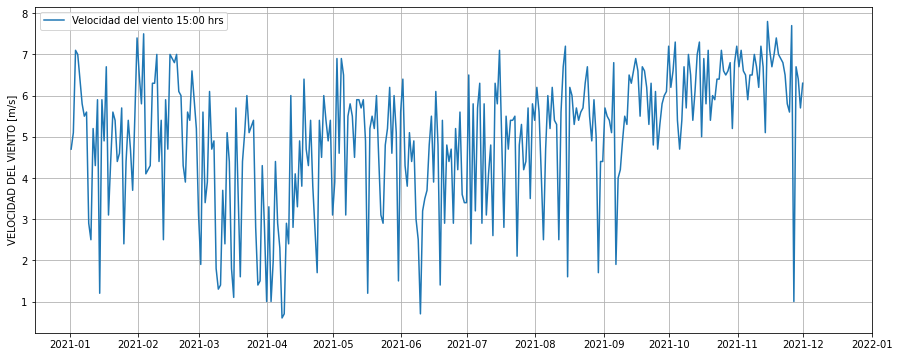

In [ ]:
# @markdown Visualización de datos de velocidad de viento [m/s]
plt.figure(figsize=(15,6))

# Eje Y izquierdo
plt.plot(df_15_hr_w['FECHA Larga'], df_15_hr_w['VELOCIDAD DEL VIENTO (m/s)'], label='Velocidad del viento 15:00 hrs')
plt.ylabel('VELOCIDAD DEL VIENTO [m/s]')
plt.legend(loc=4)

# Eje X : Fechas
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid(), plt.legend();

In [ ]:
# Fecha de toma de imagen
fecha_img = img_ee.date().format('Y-MM-dd').getInfo() # '2021-11-02'

# Velocidad del viento medido por estación meteorológica a las 15:00 [m/s]
u_w = df_15_hr_w[df_15_hr_w['FECHA']==fecha_img].iat[0,3] # numpy.float64
u_w

7.1

##### Continúa

In [ ]:
import math

u_200 = u_w*math.log(200/z_omw)/math.log(z_x/z_omw)
u_200 # (m s-1)

13.406129572198164

##### **Friction velocity (m/s)** $u*$ 

is computed during the first iteration using **the logarithmic wind law for neutral atmospheric conditions**

$$
u* = \frac{ k \; u_{200} }{ \ln{(200/z_{om})} } \; \; \; \; \qquad (31)
$$

Where:
- $u_{200}$ : wind speed (m s-1) at a blending height assumed to be 200 m, and
- $z_{om}$ : momentum roughness length (m). $z_{om}$ is a measure of the form drag and skin friction for the layer of air that interacts with the surface.
- $k$ : von Karman's constant **(0.41)**. 

$u*$ is computed for each pixel inside the process model **using a specific roughness length for each pixel**, but with $u_{200}$ assumed to be constant over all pixels of the image since it is defined as occuring at a "blending height" unaffected by surface features. Eqs. (30) and (31) support the use of a temperature gradient defined between two heights that are both above the surface. This allows one to estimate $r_{\text{ah}}$ without having to estimate a second aerodynamic roughness for sensible heat transfer ($z_{oh}$), since height $z_1$ is defined to be at an elevation above $z_{oh}$. This is an advantage because $z_{oh}$ can be difficult to estimate for sparse vegetation. 

In [ ]:
u_star = 0.41*u_200/(math.log(200/z_omw))
u_star

0.5900267935714331

##### Selección de valores de NDVI: Percentil 5

> `ee.Reducer.percentile`

https://developers.google.com/earth-engine/apidocs/ee-reducer-percentile

In [35]:
# NDVI > 0 

ndvi_gt0 = img_ndvi.select('NDVI').gt(0)
img_ndvi_gt0 = img_ndvi.updateMask(ndvi_gt0).select('NDVI')
img_ndvi_gt0.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'NDVI_max': 0.7937637681145128, 'NDVI_min': 6.846032912275756e-05}

In [46]:
percent95 = img_ndvi_gt0.reduceRegion(ee.Reducer.percentile([95]), scale=30).get('NDVI').getInfo() # P95 -> 0.5331930840838996
percent95

0.5331930840838996

In [43]:
img_ndvi_gtp95 = img_ndvi.updateMask(img_ndvi_gt0.gt(percent95)).select('NDVI')
img_ndvi_gtp95.reduceRegion(ee.Reducer.mean(), scale=30).getInfo()

{'NDVI': 0.6125658299876535}

In [40]:
# @markdown Visualización: 0 < NDVI < Percentil 5 

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'img_toa')

Map.addLayer(ndvi_gt0, vis_ndvi, 'ndvi_gt0')
Map.addLayer(img_ndvi_gt0, vis_ndvi, 'img_ndvi_gt0')
Map.addLayer(img_ndvi_gtp95, vis_ndvi, 'img_ndvi_gtp95')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

### $\lambda{ET}$ y $ET$ instantánea

### Evapotranspiración de cultivo $ET_c$ por día